In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt


# Model

## Load pretrain model

In [2]:
mobilenet_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')

14536120/14536120 [==============================] - 0s 0us/step


In [3]:
## Get label
labels = tf.keras.applications.mobilenet_v2.decode_predictions

In [7]:
labels

<function keras.src.applications.mobilenet_v2.decode_predictions(preds, top=5)>

## Preprocess image

In [15]:
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = tf.expand_dims(image, axis=0)
  # image = image[None, ...]
  return image

def get_label(probs):
  return labels(probs, top=1)[0][0]

## Example of prob image

In [32]:
def read_image(image_path):
  image_raw = tf.io.read_file(image_path)

  image = tf.image.decode_image(image_raw)
  image = preprocess_image(image)
  return image

def plot(model, image, description=""):
  image_probs = model.predict(image)
  _, image_class, class_confidence = get_label(image_probs)
  plt.figure(figsize=(7,7))
  plt.imshow(image[0]*0.5+0.5)
  if description!="":
    plt.title('{}\n{} : {:.2f}% Confidence'.format(description, image_class, class_confidence*100))
  else:
    plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
  plt.show()

1/1 [==============================] - 0s 21ms/step


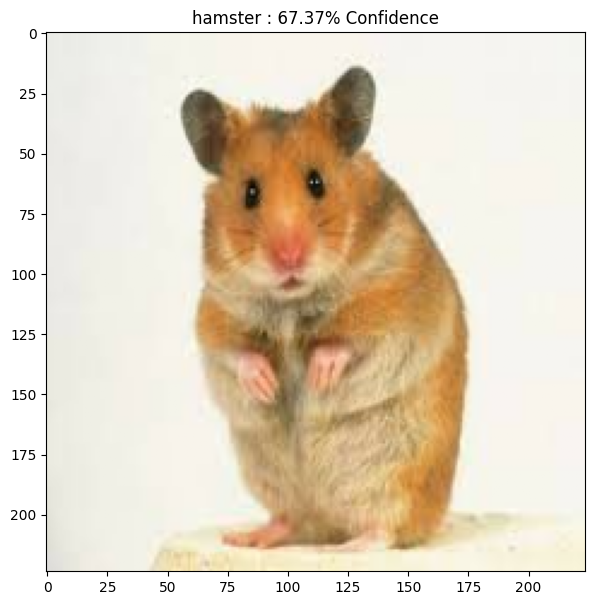

In [21]:
IMAGE_PATH = "./hamster.jpg"
image = read_image(IMAGE_PATH)
plot(mobilenet_model, image)

# FGSM Attack

## Calculate gradient

In [23]:
loss_func= tf.keras.losses.CategoricalCrossentropy()

def create_adv_per(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = mobilenet_model(input_image)
    loss = loss_func(input_label, prediction)
  gradient = tape.gradient(loss, input_image)
  signed_grad = tf.sign(gradient)
  return signed_grad

1/1 [==============================] - 0s 41ms/step


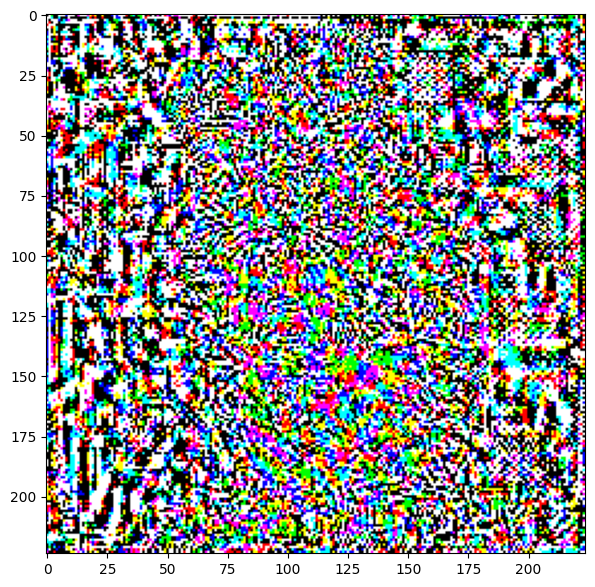

In [24]:
target_label = 2
image_probs = mobilenet_model.predict(image)
label = tf.one_hot(target_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adv_per(image, label)
plt.figure(figsize=(7,7))
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]


## Attack

1/1 [==============================] - 0s 22ms/step


<ipython-input-33-c53c9e9f6946>:13: RuntimeWarning: divide by zero encountered in divide
  psnr = 10* np.log10((255**2)/mse)


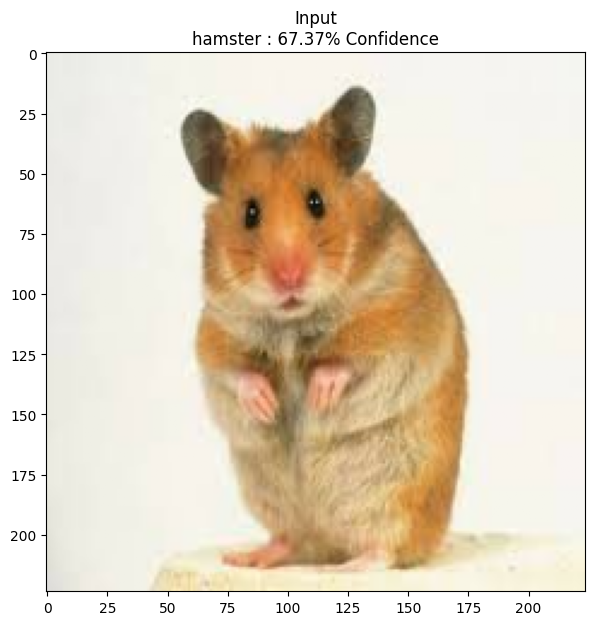

1/1 [==============================] - 0s 22ms/step


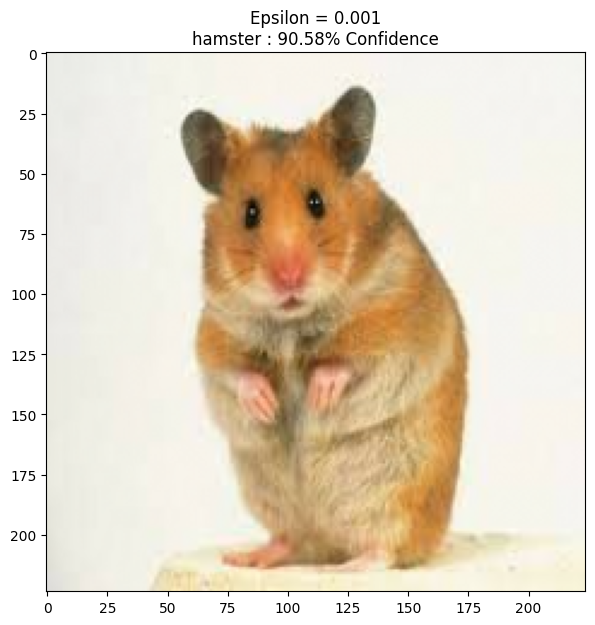

1/1 [==============================] - 0s 21ms/step


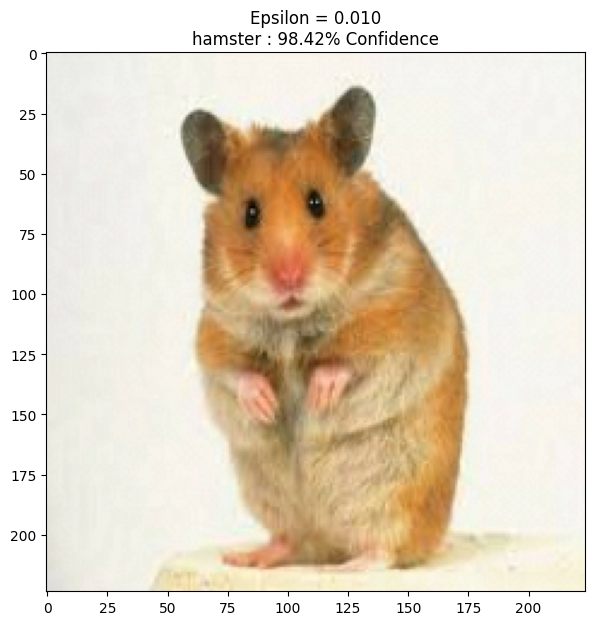

1/1 [==============================] - 0s 23ms/step


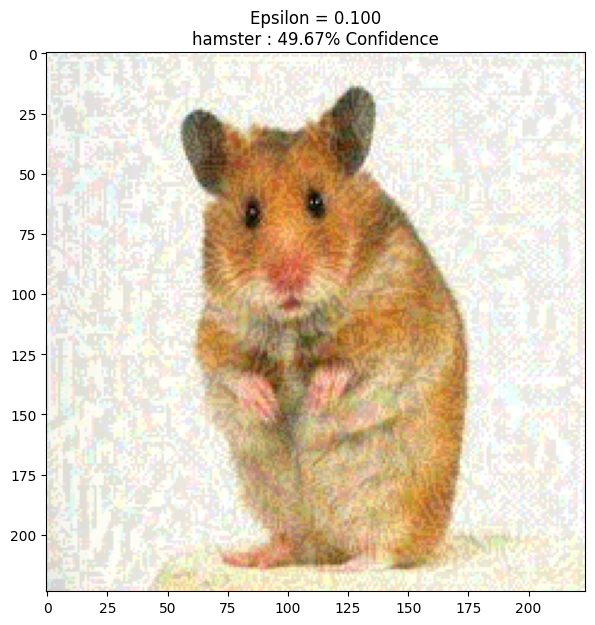

1/1 [==============================] - 0s 31ms/step


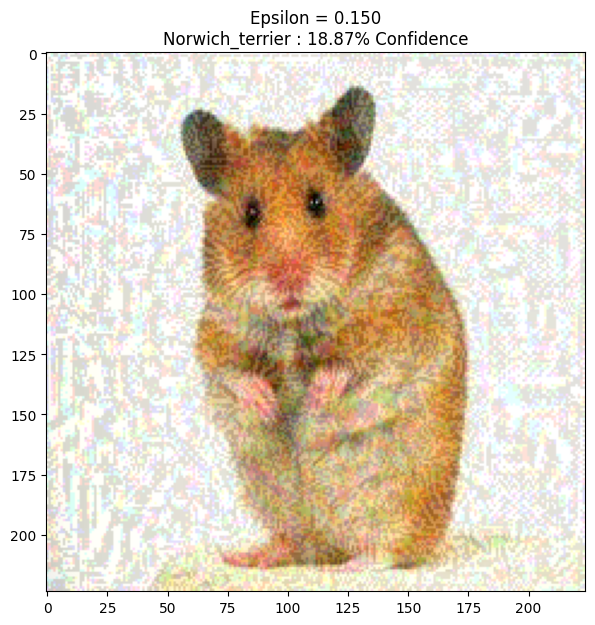

1/1 [==============================] - 0s 34ms/step


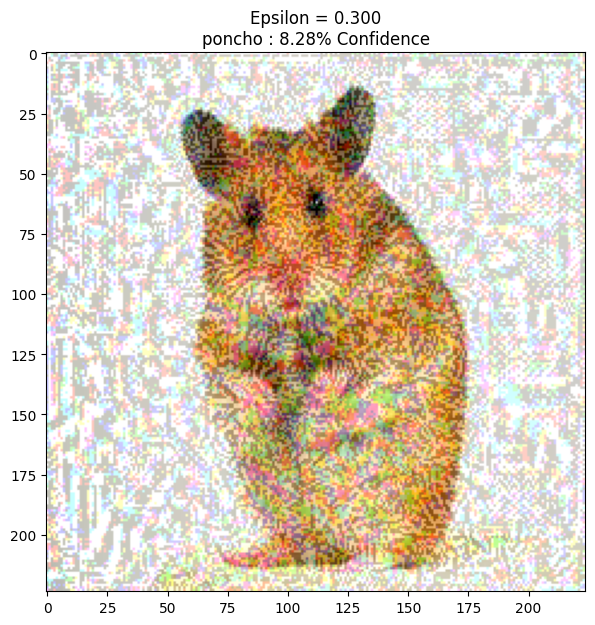

In [33]:
from skimage import color
import numpy as np
epsilons = [0,0.001, 0.01, 0.1, 0.15,0.3]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations
  adv_x = tf.clip_by_value(adv_x, -1, 1)
  image_gray = color.rgb2gray(image)
  adv_gray = color.rgb2gray(adv_x)
  mse = np.mean((image_gray - adv_gray)**2)
  psnr = 10* np.log10((255**2)/mse)
  # print("PSNR:{:.2f} ".format(psnr))
  L1 = 1/(tf.size(image).numpy())*np.sum(abs(image-adv_x))
  L2 = 1/(tf.size(image).numpy())*np.sum((image-adv_x)**2)
  # print("L1 loss:{:.2f}".format(L1))
  # print("L2 loss:{:.2f}".format(L2))
  plot(mobilenet_model, adv_x, descriptions[i])
  # plt.figure()
  # plt.imshow(adv_x[0])
  # plt.title(descriptions[i])
  # plt.show()
  # display_images(adv_x, descriptions[i])
